<a href="https://colab.research.google.com/github/tuhuayuan/edhec_mooc2/blob/master/lab_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clone or Update the mooc repo.
%cd /content/drive/MyDrive/Colab Notebooks
!git -C edhec_mooc2 pull || git clone -l -s https://github.com/tuhuayuan/edhec_mooc2.git edhec_mooc2
!ln -sf '/content/drive/MyDrive/Colab Notebooks/edhec_mooc2' /content/edhec_mooc2
%cd /content/edhec_mooc2

/content/drive/MyDrive/Colab Notebooks
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
Cloning into 'edhec_mooc2'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 55 (delta 11), reused 42 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), done.
/content/drive/MyDrive/Colab Notebooks/edhec_mooc2


# Estimating Covariance and Expected Returns

We've backtested CW and EW Portfolios and they each have unique positions in industrial implementations.

CapWeighted portfolios are the overall average and hence the de-facto industry standard. They are very inexpensive to implement and feature very low turnover. In many ways, they are the default go-to implementation choice for many investors.

However, we've seen that they suffer from some disadvantages, so there is some room for improvement.

EW are the most obvious improvement because they are the only other technique we are going to look at (other than CW) that requires no estimation of either covariance or expected returns. We've already backtested those and we've seen how easy they are to build.

We'll now move on the more sophisticated portfolio construction techniques, but they will get us involved in the estimation game, something we've avoided so far ... so let's start by pulling in the data we need and start with the CW and EW portfolios, since they are the baseline portfolios.

- **一般来讲，金融时间序列的波动具有大波动接着大波动，小波动接着小波动的特征，即波峰和波谷具有连续性。在高波动的时候，人们情绪高涨市场的势能不断积累，于是会转化成更大的波动；在低波动的时候，人们对市场的兴趣越来越低，市场逐渐会成为一摊死水。此外，金融事件序列存在波动的不对称性，在上涨时候的波动率会小于下跌时候的波动率。**
- **自回归模型，是统计上一种处理时间序列的方法，是用同一变量之前各期的表现情况，来预测该变量本期的表现情况，并假设它们为线性关系。因为这是从回归分析中的线性回归发展而来，只是不是用来预测其他变量，而是用来预测自己，所以叫做自回归。**

In [ ]:
import numpy as np
import pandas as pd

%reload_ext google.colab.data_table

import edhec_risk_kit_205 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="ew", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.59806
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.58785


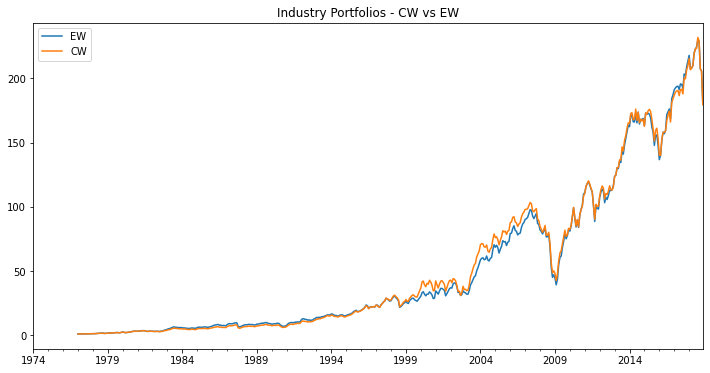

In [ ]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

# Building the Global Minimum Variance Portfolio

We've previously written the code (in MOOC 1) to build the GMV portfolio, given the covariance. Let's start with just that:


In [ ]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)


Now, let's run this new backtest. This may take a fair amount of time to run, so be patient - we are running a backtest over nearly 50 years and both optimizing and rebalancing on a monthly basis ... this will take a while!

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153093,0.116303,-0.811371,6.408588,0.047674,0.072557,1.030061,-0.463911


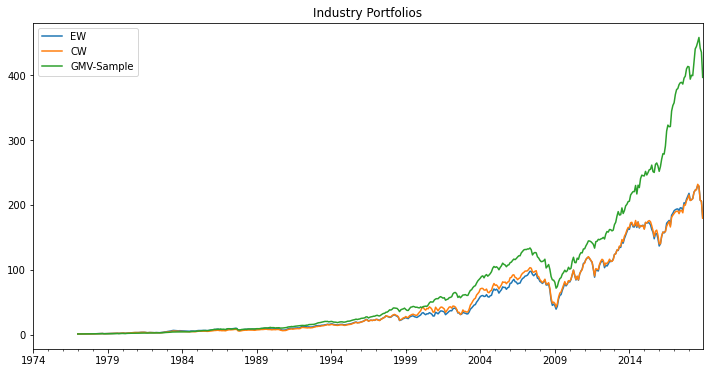

In [ ]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


In [ ]:
#import statsmodels.stats.moment_helpers as mh
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

In [ ]:
%timeit cc_cov(ind_rets.iloc[:60])

1000 loops, best of 5: 1.13 ms per loop


In [ ]:
%timeit sample_cov(ind_rets.iloc[:60])

1000 loops, best of 5: 740 µs per loop


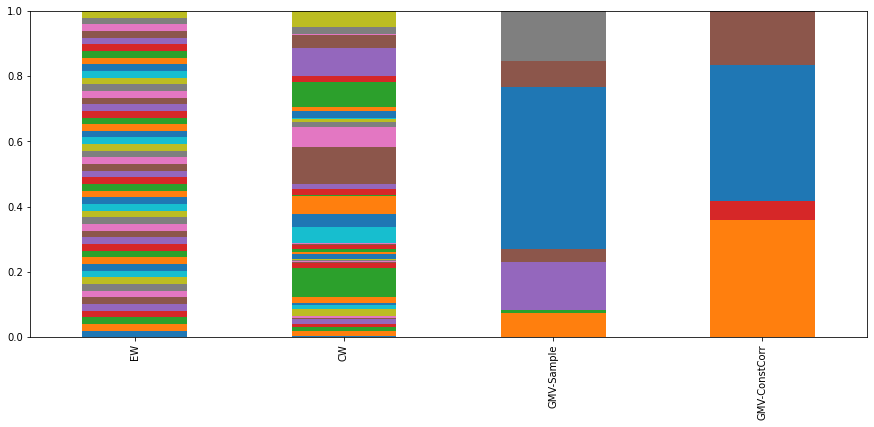

In [ ]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2016":]),
    "CW": erk.weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.125907,0.187458,-0.543515,6.688064,0.081528,0.121461,0.497733,-0.598060
CW,0.126971,0.187616,-0.475904,5.709611,0.081629,0.119573,0.502835,-0.587850
GMV-Sample,0.152911,0.116914,-0.790528,6.393053,0.047827,0.073017,1.023165,-0.463911
GMV-CC,0.127521,0.114639,-0.726802,5.256934,0.048771,0.074783,0.827868,-0.518560


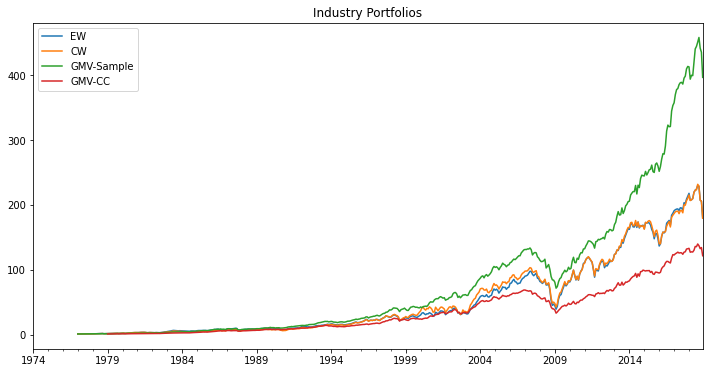

In [ ]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=60, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practiotioners choose $0.5$. Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

In [ ]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample


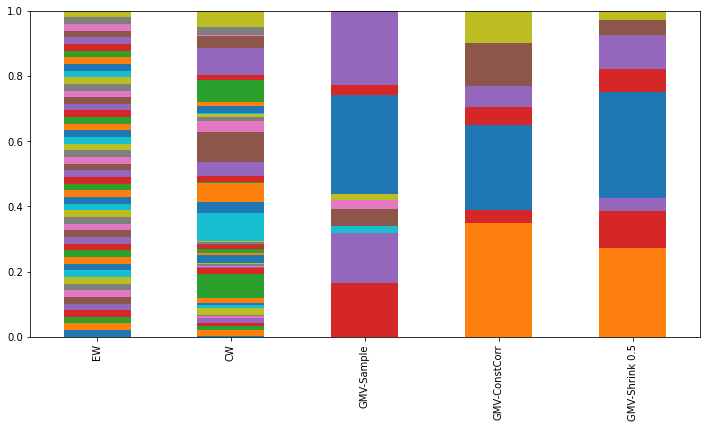

In [ ]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2013":]),
    "CW": erk.weight_cw(ind_rets["2013":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.1259,0.1875,-0.5435,6.6881,0.0815,0.1215,0.4977,-0.5981
CW,0.1270,0.1876,-0.4759,5.7096,0.0816,0.1196,0.5028,-0.5879
GMV-Sample,0.1529,0.1169,-0.7905,6.3931,0.0478,0.0730,1.0232,-0.4639
GMV-CC,0.1275,0.1146,-0.7268,5.2569,0.0488,0.0748,0.8279,-0.5186
GMV-Shrink 0.5,0.1376,0.1155,-0.8579,6.2572,0.0489,0.0746,0.9073,-0.5185


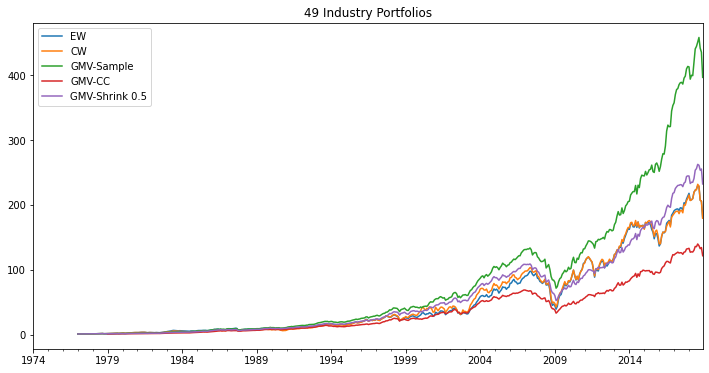

In [ ]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna()).round(4)